Jane, our friend at the bird-watching club, has set up a fleet of cameras in the woods
south of the airport. The cameras are supposed to save a shot when something enters
the frame and upload it to the club’s real-time bird-watching blog. The problem is
that a lot of planes coming and going from the airport end up triggering the camera. so Jane spends a lot of time deleting pictures of airplanes from the blog. What she
needs is an automated system that throws away the airplane.

In [1]:
import torch
from torch.utils.data import DataLoader
from torch import optim
from torchvision import datasets
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import datetime

In [2]:
train=datasets.CIFAR10(root='data',
                      train=True,
                      download=True,
                      transform=transforms.ToTensor())

Extracting data/cifar-10-python.tar.gz to data


In [3]:
test=datasets.CIFAR10(root='data',
                      train=False,
                      download=True,
                      transform=transforms.ToTensor())

Files already downloaded and verified


In [4]:
label_class={
0:'airplane',
1:'automobile',
2:'bird',
3:'cat',
4:'deer',
5:'dog',
6:'frog',
7:'horse',
8:'ship',
9:'truck'
}

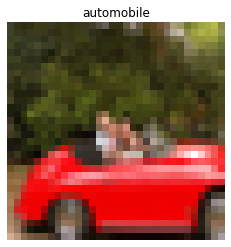

In [5]:
img,label=train[99]
plt.title(label_class[label])
plt.axis('off')
plt.imshow(img.permute(1,2,0))

In [6]:
img.shape

torch.Size([3, 32, 32])

Since we only need airplane and birds from the Cifar10 dataset which contains 10 different item images, we are going to select only the birds and airplane data from the dataset.

In [7]:
label_map = {0: 0, 2: 1}
cifar_2_train=[(img,label_map[label]) for img,label in train if label in [0,2]]
cifar_2_test=[(img,label_map[label]) for img,label in test if label in [0,2]]

In [8]:
train_loader=DataLoader(cifar_2_train, batch_size=64,shuffle=True)

Let's try to build a more better convolutional neural network with more channels and add the regularization methods L2 and Dropout to know if they can improve our model.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.drop_out_1=nn.Dropout2d(p=.4)
        self.conv2 = nn.Conv2d(128, 32, kernel_size=3, padding=1)
        self.drop_out_2=nn.Dropout2d(p=.4)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.drop_out_1(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.drop_out_2(out)
        out = out.view(-1, 32 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        out = self.fc3(out)
        return out

Let's train the model in GPU

In [13]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')
    
model = Net().to(device)

In [14]:
optimizer=optim.Adam(model.parameters(),1e-4)
loss_fn=nn.CrossEntropyLoss()

In [15]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        for imgs,labels in train_loader:
            imgs=imgs.to(device)
            labels = labels.to(device)
            output=model(imgs)
            
            loss=loss_fn(output, torch.tensor(labels))
            
            #L2 Regularization
            l2_lambda=0.001
            l2_norm=sum(p.pow(2).sum() for p in model.parameters())
            loss=loss+l2_lambda*l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch,
                                                         loss_train / len(train_loader)))

In [16]:
training_loop(
n_epochs = 100,
optimizer = optimizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


2021-03-16 17:20:37.822548 Epoch 1, Training loss 0.6667623489525667
2021-03-16 17:20:46.329826 Epoch 10, Training loss 0.42444847780428113
2021-03-16 17:20:55.539584 Epoch 20, Training loss 0.37300287965376666
2021-03-16 17:21:04.643809 Epoch 30, Training loss 0.3406416923756812
2021-03-16 17:21:14.054858 Epoch 40, Training loss 0.3199609541779111
2021-03-16 17:21:23.212286 Epoch 50, Training loss 0.2937381872136122
2021-03-16 17:21:32.378455 Epoch 60, Training loss 0.27243879570323193
2021-03-16 17:21:41.591833 Epoch 70, Training loss 0.2579378379378349
2021-03-16 17:21:50.751510 Epoch 80, Training loss 0.24075474319564308
2021-03-16 17:21:59.933473 Epoch 90, Training loss 0.23007766114678352
2021-03-16 17:22:09.137707 Epoch 100, Training loss 0.21407077675032768


In [17]:
test_loader=DataLoader(cifar_2_test,batch_size=64,shuffle=False)
train_loader=DataLoader(cifar_2_train,batch_size=64,shuffle=False)

In [22]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs=imgs.to(device)
                labels=labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [23]:
validate(model, train_loader, test_loader)

Accuracy train: 0.95
Accuracy val: 0.89


So my new version has a training set accuracy of 95% and a validation set accuracy of 89%  in detecting birds and airplane accurately. Woohoo! That's cool. I have sucessfully built a highly accurate model that can distinguish airplane and birds in the sky. So, what am I waiting for? Let's save the model. 

Lets save the model

In [ ]:
torch.save(model.state_dict(), './' + 'birds_vs_airplanes.pt')

To load the model,

In [ ]:
loaded_model=Net()
loaded_model.load_state_dict(torch.load('./'+ 'birds_vs_airplanes.pt',map_location=device))